In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from stable_baselines3 import PPO  # Change 1: Import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback, CallbackList, EvalCallback
from asv_glider_bearing_dist_env import AsvGliderBearingEnv

# --- 1. Define the Rollout Callback ---
class TrajectoryPlotCallback(BaseCallback):
    def __init__(self, eval_env, render_freq=10000, log_dir="./rollouts/"):
        super().__init__()
        self.eval_env = eval_env
        self.render_freq = render_freq
        self.log_dir = log_dir
        os.makedirs(self.log_dir, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.render_freq == 0:
            obs, _ = self.eval_env.reset(seed=123) 
            asv_history, glider_history = [], []
            done = False
            
            lstm_states = None
            episode_starts = np.ones((1,), dtype=bool)

            while not done:
                action, _ = self.model.predict(
                    obs, 
                    state=lstm_states, 
                    episode_start=episode_starts, 
                    deterministic=True
                )
                obs, reward, terminated, truncated, _ = self.eval_env.step(action)
                
                asv_history.append(self.eval_env.unwrapped.asv_pos.copy())
                glider_history.append(self.eval_env.unwrapped.glider_pos.copy())
                
                done = terminated or truncated

            asv_history, glider_history = np.array(asv_history), np.array(glider_history)
            
            plt.figure(figsize=(6, 6))
            plt.plot(glider_history[:, 0], glider_history[:, 1], 'g--', label="Glider Path", alpha=0.6)
            plt.plot(asv_history[:, 0], asv_history[:, 1], 'b-', label="ASV Path (PPO)", linewidth=2)
            plt.title(f"PPO Rollout at Step {self.n_calls}")
            plt.xlabel("X Position (m)")
            plt.ylabel("Y Position (m)")
            plt.legend()
            plt.grid(True)
            
            save_path = os.path.join(self.log_dir, f"rollout_{self.n_calls}.png")
            plt.savefig(save_path)
            plt.close()
            print(f">>> Saved PPO rollout to {save_path}")
        return True

# --- 2. Setup Directories and Environments ---
algo_name = "ppo" 
base_path = f"./experiments/{algo_name}/"
os.makedirs(base_path, exist_ok=True)

env = AsvGliderBearingEnv()
env = Monitor(env, os.path.join(base_path, "training_logs"))

eval_env = AsvGliderBearingEnv()
eval_env = Monitor(eval_env, os.path.join(base_path, "eval_logs"))

# --- 3. Initialize PPO Model ---
# Note: PPO typically uses n_steps * n_envs to determine the batch size for updates
model = PPO(
    "MlpPolicy",
    env,
    verbose=1,
    learning_rate=3e-4,   # PPO usually prefers a slightly higher learning rate than SAC/TD3
    n_steps=2048,         # Number of steps to run for each environment per update
    batch_size=64,        # Minibatch size
    n_epochs=10,          # Number of epochs when optimizing the surrogate loss
    gamma=0.99,
    gae_lambda=0.95,      # Factor for trade-off of bias vs variance for GAE
    clip_range=0.2,       # Clipping parameter
    device="cuda",
)

# --- 4. Callbacks ---
eval_callback = EvalCallback(
    eval_env, 
    best_model_save_path=os.path.join(base_path, "best_model"),
    log_path=os.path.join(base_path, "eval_results"), 
    eval_freq=5000,
    deterministic=True,
    render=False
)

plot_callback = TrajectoryPlotCallback(
    eval_env, 
    render_freq=10000, 
    log_dir=os.path.join(base_path, "rollouts")
)

callbacks = CallbackList([eval_callback, plot_callback])

# --- 5. Train ---
try:
    print(f"Starting training for {algo_name}...")
    model.learn(
        total_timesteps=100_000, 
        callback=callbacks,
        progress_bar=True
    )
except KeyboardInterrupt:
    print("\nTraining interrupted.")
finally:
    env.close()
    eval_env.close()
    model.save(os.path.join(base_path, f"{algo_name}_final_model"))
    print("Environment closed and PPO model saved.")

Output()

Using cuda device
Wrapping the env in a DummyVecEnv.
Starting training for ppo...


/home/svillhauer/.local/lib/python3.10/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


----------------------------------
| rollout/           |           |
|    ep_len_mean     | 1e+03     |
|    ep_rew_mean     | -1.21e+03 |
| time/              |           |
|    fps             | 1617      |
|    iterations      | 1         |
|    time_elapsed    | 1         |
|    total_timesteps | 2048      |
----------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -738        |
| time/                   |             |
|    fps                  | 1281        |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.015048263 |
|    clip_fraction        | 0.173       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.84       |
|    explained_variance   | 0.0044      |
|    learning_rate        | 0.0003      |
|    loss                 | 79.2        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0257     |
|    std                  | 0.997       |
|    value_loss           | 324         |
-----------------------------------------


Eval num_timesteps=5000, episode_reward=-388.09 +/- 847.64

Episode length: 1000.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1e+03       |
|    mean_reward          | -388        |
| time/                   |             |
|    total_timesteps      | 5000        |
| train/                  |             |
|    approx_kl            | 0.014958577 |
|    clip_fraction        | 0.176       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.81       |
|    explained_variance   | 0.139       |
|    learning_rate        | 0.0003      |
|    loss                 | 45.8        |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.0179     |
|    std                  | 0.981       |
|    value_loss           | 121         |
-----------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -525     |
| time/              |          |
|    fps             | 860      |
|    iterations      | 3        |
|    time_elapsed    | 7        |
|    total_timesteps | 6144     |
---------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -384        |
| time/                   |             |
|    fps                  | 896         |
|    iterations           | 4           |
|    time_elapsed         | 9           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.018522438 |
|    clip_fraction        | 0.187       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.79       |
|    explained_variance   | 0.429       |
|    learning_rate        | 0.0003      |
|    loss                 | 40.7        |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.023      |
|    std                  | 0.971       |
|    value_loss           | 79.4        |
-----------------------------------------


Eval num_timesteps=10000, episode_reward=90.36 +/- 642.86

Episode length: 1000.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1e+03       |
|    mean_reward          | 90.4        |
| time/                   |             |
|    total_timesteps      | 10000       |
| train/                  |             |
|    approx_kl            | 0.013190048 |
|    clip_fraction        | 0.176       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.76       |
|    explained_variance   | 0.533       |
|    learning_rate        | 0.0003      |
|    loss                 | 99.7        |
|    n_updates            | 40          |
|    policy_gradient_loss | -0.0221     |
|    std                  | 0.956       |
|    value_loss           | 162         |
-----------------------------------------


New best mean reward!

>>> Saved PPO rollout to ./experiments/ppo/rollouts/rollout_10000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -415     |
| time/              |          |
|    fps             | 751      |
|    iterations      | 5        |
|    time_elapsed    | 13       |
|    total_timesteps | 10240    |
---------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -464        |
| time/                   |             |
|    fps                  | 784         |
|    iterations           | 6           |
|    time_elapsed         | 15          |
|    total_timesteps      | 12288       |
| train/                  |             |
|    approx_kl            | 0.016845606 |
|    clip_fraction        | 0.152       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.73       |
|    explained_variance   | -0.128      |
|    learning_rate        | 0.0003      |
|    loss                 | 49.9        |
|    n_updates            | 50          |
|    policy_gradient_loss | -0.0186     |
|    std                  | 0.939       |
|    value_loss           | 152         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -448        |
| time/                   |             |
|    fps                  | 812         |
|    iterations           | 7           |
|    time_elapsed         | 17          |
|    total_timesteps      | 14336       |
| train/                  |             |
|    approx_kl            | 0.019822598 |
|    clip_fraction        | 0.207       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.71       |
|    explained_variance   | 0.00747     |
|    learning_rate        | 0.0003      |
|    loss                 | 85.3        |
|    n_updates            | 60          |
|    policy_gradient_loss | -0.0231     |
|    std                  | 0.93        |
|    value_loss           | 133         |
-----------------------------------------


Eval num_timesteps=15000, episode_reward=196.34 +/- 805.93

Episode length: 1000.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1e+03       |
|    mean_reward          | 196         |
| time/                   |             |
|    total_timesteps      | 15000       |
| train/                  |             |
|    approx_kl            | 0.009178042 |
|    clip_fraction        | 0.0806      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.67       |
|    explained_variance   | 0.125       |
|    learning_rate        | 0.0003      |
|    loss                 | 119         |
|    n_updates            | 70          |
|    policy_gradient_loss | -0.0104     |
|    std                  | 0.916       |
|    value_loss           | 376         |
-----------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -305     |
| time/              |          |
|    fps             | 757      |
|    iterations      | 8        |
|    time_elapsed    | 21       |
|    total_timesteps | 16384    |
---------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -326        |
| time/                   |             |
|    fps                  | 781         |
|    iterations           | 9           |
|    time_elapsed         | 23          |
|    total_timesteps      | 18432       |
| train/                  |             |
|    approx_kl            | 0.017896507 |
|    clip_fraction        | 0.137       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.65       |
|    explained_variance   | 0.187       |
|    learning_rate        | 0.0003      |
|    loss                 | 62.6        |
|    n_updates            | 80          |
|    policy_gradient_loss | -0.0181     |
|    std                  | 0.907       |
|    value_loss           | 167         |
-----------------------------------------


Eval num_timesteps=20000, episode_reward=280.54 +/- 766.97

Episode length: 1000.00 +/- 0.00

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 1e+03      |
|    mean_reward          | 281        |
| time/                   |            |
|    total_timesteps      | 20000      |
| train/                  |            |
|    approx_kl            | 0.00520138 |
|    clip_fraction        | 0.0275     |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.64      |
|    explained_variance   | -0.554     |
|    learning_rate        | 0.0003     |
|    loss                 | 106        |
|    n_updates            | 90         |
|    policy_gradient_loss | -0.00358   |
|    std                  | 0.906      |
|    value_loss           | 353        |
----------------------------------------


New best mean reward!

>>> Saved PPO rollout to ./experiments/ppo/rollouts/rollout_20000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -303     |
| time/              |          |
|    fps             | 731      |
|    iterations      | 10       |
|    time_elapsed    | 28       |
|    total_timesteps | 20480    |
---------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 1e+03     |
|    ep_rew_mean          | -245      |
| time/                   |           |
|    fps                  | 750       |
|    iterations           | 11        |
|    time_elapsed         | 30        |
|    total_timesteps      | 22528     |
| train/                  |           |
|    approx_kl            | 0.0066743 |
|    clip_fraction        | 0.0546    |
|    clip_range           | 0.2       |
|    entropy_loss         | -2.62     |
|    explained_variance   | 0.0513    |
|    learning_rate        | 0.0003    |
|    loss                 | 141       |
|    n_updates            | 100       |
|    policy_gradient_loss | -0.00835  |
|    std                  | 0.888     |
|    value_loss           | 312       |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -271        |
| time/                   |             |
|    fps                  | 766         |
|    iterations           | 12          |
|    time_elapsed         | 32          |
|    total_timesteps      | 24576       |
| train/                  |             |
|    approx_kl            | 0.011541782 |
|    clip_fraction        | 0.135       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.59       |
|    explained_variance   | -0.0889     |
|    learning_rate        | 0.0003      |
|    loss                 | 106         |
|    n_updates            | 110         |
|    policy_gradient_loss | -0.0141     |
|    std                  | 0.881       |
|    value_loss           | 242         |
-----------------------------------------


Eval num_timesteps=25000, episode_reward=282.23 +/- 606.01

Episode length: 1000.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1e+03       |
|    mean_reward          | 282         |
| time/                   |             |
|    total_timesteps      | 25000       |
| train/                  |             |
|    approx_kl            | 0.006774219 |
|    clip_fraction        | 0.0328      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.58       |
|    explained_variance   | 0.162       |
|    learning_rate        | 0.0003      |
|    loss                 | 124         |
|    n_updates            | 120         |
|    policy_gradient_loss | -0.00559    |
|    std                  | 0.88        |
|    value_loss           | 291         |
-----------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -165     |
| time/              |          |
|    fps             | 737      |
|    iterations      | 13       |
|    time_elapsed    | 36       |
|    total_timesteps | 26624    |
---------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | -161         |
| time/                   |              |
|    fps                  | 751          |
|    iterations           | 14           |
|    time_elapsed         | 38           |
|    total_timesteps      | 28672        |
| train/                  |              |
|    approx_kl            | 0.0065763295 |
|    clip_fraction        | 0.0344       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.57        |
|    explained_variance   | 0.114        |
|    learning_rate        | 0.0003       |
|    loss                 | 108          |
|    n_updates            | 130          |
|    policy_gradient_loss | -0.0039      |
|    std                  | 0.87         |
|    value_loss           | 370          |
------------------------------------------


Eval num_timesteps=30000, episode_reward=219.53 +/- 798.63

Episode length: 1000.00 +/- 0.00

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1e+03        |
|    mean_reward          | 220          |
| time/                   |              |
|    total_timesteps      | 30000        |
| train/                  |              |
|    approx_kl            | 0.0091019925 |
|    clip_fraction        | 0.0953       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.54        |
|    explained_variance   | 0.265        |
|    learning_rate        | 0.0003       |
|    loss                 | 99.3         |
|    n_updates            | 140          |
|    policy_gradient_loss | -0.0117      |
|    std                  | 0.858        |
|    value_loss           | 218          |
------------------------------------------


>>> Saved PPO rollout to ./experiments/ppo/rollouts/rollout_30000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -136     |
| time/              |          |
|    fps             | 721      |
|    iterations      | 15       |
|    time_elapsed    | 42       |
|    total_timesteps | 30720    |
---------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | -63.6        |
| time/                   |              |
|    fps                  | 735          |
|    iterations           | 16           |
|    time_elapsed         | 44           |
|    total_timesteps      | 32768        |
| train/                  |              |
|    approx_kl            | 0.0071315607 |
|    clip_fraction        | 0.0616       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.53        |
|    explained_variance   | 0.144        |
|    learning_rate        | 0.0003       |
|    loss                 | 195          |
|    n_updates            | 150          |
|    policy_gradient_loss | -0.00669     |
|    std                  | 0.856        |
|    value_loss           | 442          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -88.1       |
| time/                   |             |
|    fps                  | 747         |
|    iterations           | 17          |
|    time_elapsed         | 46          |
|    total_timesteps      | 34816       |
| train/                  |             |
|    approx_kl            | 0.011067689 |
|    clip_fraction        | 0.0892      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.53       |
|    explained_variance   | -0.124      |
|    learning_rate        | 0.0003      |
|    loss                 | 65.4        |
|    n_updates            | 160         |
|    policy_gradient_loss | -0.00906    |
|    std                  | 0.858       |
|    value_loss           | 178         |
-----------------------------------------


Eval num_timesteps=35000, episode_reward=785.89 +/- 921.26

Episode length: 1000.00 +/- 0.00

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1e+03        |
|    mean_reward          | 786          |
| time/                   |              |
|    total_timesteps      | 35000        |
| train/                  |              |
|    approx_kl            | 0.0034661014 |
|    clip_fraction        | 0.0413       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.53        |
|    explained_variance   | 0.102        |
|    learning_rate        | 0.0003       |
|    loss                 | 91.7         |
|    n_updates            | 170          |
|    policy_gradient_loss | -0.00487     |
|    std                  | 0.854        |
|    value_loss           | 304          |
------------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -24.9    |
| time/              |          |
|    fps             | 727      |
|    iterations      | 18       |
|    time_elapsed    | 50       |
|    total_timesteps | 36864    |
---------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 29.6        |
| time/                   |             |
|    fps                  | 737         |
|    iterations           | 19          |
|    time_elapsed         | 52          |
|    total_timesteps      | 38912       |
| train/                  |             |
|    approx_kl            | 0.009545576 |
|    clip_fraction        | 0.0848      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.5        |
|    explained_variance   | 0.327       |
|    learning_rate        | 0.0003      |
|    loss                 | 91.3        |
|    n_updates            | 180         |
|    policy_gradient_loss | -0.0104     |
|    std                  | 0.837       |
|    value_loss           | 250         |
-----------------------------------------


Eval num_timesteps=40000, episode_reward=1014.45 +/- 1288.35

Episode length: 1000.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1e+03       |
|    mean_reward          | 1.01e+03    |
| time/                   |             |
|    total_timesteps      | 40000       |
| train/                  |             |
|    approx_kl            | 0.008293056 |
|    clip_fraction        | 0.0397      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.46       |
|    explained_variance   | -0.323      |
|    learning_rate        | 0.0003      |
|    loss                 | 103         |
|    n_updates            | 190         |
|    policy_gradient_loss | -0.00735    |
|    std                  | 0.822       |
|    value_loss           | 286         |
-----------------------------------------


New best mean reward!

>>> Saved PPO rollout to ./experiments/ppo/rollouts/rollout_40000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 89.4     |
| time/              |          |
|    fps             | 715      |
|    iterations      | 20       |
|    time_elapsed    | 57       |
|    total_timesteps | 40960    |
---------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 182          |
| time/                   |              |
|    fps                  | 725          |
|    iterations           | 21           |
|    time_elapsed         | 59           |
|    total_timesteps      | 43008        |
| train/                  |              |
|    approx_kl            | 0.0046708253 |
|    clip_fraction        | 0.0277       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.44        |
|    explained_variance   | 0.0391       |
|    learning_rate        | 0.0003       |
|    loss                 | 220          |
|    n_updates            | 200          |
|    policy_gradient_loss | -0.00536     |
|    std                  | 0.819        |
|    value_loss           | 738          |
------------------------------------------


Eval num_timesteps=45000, episode_reward=176.61 +/- 1205.65

Episode length: 1000.00 +/- 0.00

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1e+03        |
|    mean_reward          | 177          |
| time/                   |              |
|    total_timesteps      | 45000        |
| train/                  |              |
|    approx_kl            | 0.0071825944 |
|    clip_fraction        | 0.0804       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.43        |
|    explained_variance   | 0.327        |
|    learning_rate        | 0.0003       |
|    loss                 | 186          |
|    n_updates            | 210          |
|    policy_gradient_loss | -0.0087      |
|    std                  | 0.813        |
|    value_loss           | 354          |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 163      |
| time/              |          |
|    fps     

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 195         |
| time/                   |             |
|    fps                  | 719         |
|    iterations           | 23          |
|    time_elapsed         | 65          |
|    total_timesteps      | 47104       |
| train/                  |             |
|    approx_kl            | 0.006609237 |
|    clip_fraction        | 0.113       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.42       |
|    explained_variance   | -0.0967     |
|    learning_rate        | 0.0003      |
|    loss                 | 471         |
|    n_updates            | 220         |
|    policy_gradient_loss | -0.00798    |
|    std                  | 0.804       |
|    value_loss           | 954         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 227         |
| time/                   |             |
|    fps                  | 727         |
|    iterations           | 24          |
|    time_elapsed         | 67          |
|    total_timesteps      | 49152       |
| train/                  |             |
|    approx_kl            | 0.009237474 |
|    clip_fraction        | 0.104       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.4        |
|    explained_variance   | 0.00432     |
|    learning_rate        | 0.0003      |
|    loss                 | 198         |
|    n_updates            | 230         |
|    policy_gradient_loss | -0.00808    |
|    std                  | 0.802       |
|    value_loss           | 345         |
-----------------------------------------


Eval num_timesteps=50000, episode_reward=1078.13 +/- 890.00

Episode length: 1000.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1e+03       |
|    mean_reward          | 1.08e+03    |
| time/                   |             |
|    total_timesteps      | 50000       |
| train/                  |             |
|    approx_kl            | 0.009766392 |
|    clip_fraction        | 0.124       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.38       |
|    explained_variance   | -0.0337     |
|    learning_rate        | 0.0003      |
|    loss                 | 202         |
|    n_updates            | 240         |
|    policy_gradient_loss | -0.00181    |
|    std                  | 0.789       |
|    value_loss           | 455         |
-----------------------------------------


New best mean reward!

>>> Saved PPO rollout to ./experiments/ppo/rollouts/rollout_50000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 236      |
| time/              |          |
|    fps             | 710      |
|    iterations      | 25       |
|    time_elapsed    | 72       |
|    total_timesteps | 51200    |
---------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 245         |
| time/                   |             |
|    fps                  | 719         |
|    iterations           | 26          |
|    time_elapsed         | 74          |
|    total_timesteps      | 53248       |
| train/                  |             |
|    approx_kl            | 0.013557371 |
|    clip_fraction        | 0.132       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.36       |
|    explained_variance   | 0.36        |
|    learning_rate        | 0.0003      |
|    loss                 | 120         |
|    n_updates            | 250         |
|    policy_gradient_loss | -0.0131     |
|    std                  | 0.792       |
|    value_loss           | 266         |
-----------------------------------------


Eval num_timesteps=55000, episode_reward=455.96 +/- 989.47

Episode length: 1000.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1e+03       |
|    mean_reward          | 456         |
| time/                   |             |
|    total_timesteps      | 55000       |
| train/                  |             |
|    approx_kl            | 0.015139806 |
|    clip_fraction        | 0.153       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.38       |
|    explained_variance   | -0.00939    |
|    learning_rate        | 0.0003      |
|    loss                 | 198         |
|    n_updates            | 260         |
|    policy_gradient_loss | -0.00561    |
|    std                  | 0.804       |
|    value_loss           | 366         |
-----------------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 250      |
| time/              |          |
|    fps             | 706      |
|    iterations      | 27       |
|    time_elapsed    | 78       |
|    total_timesteps | 55296    |
---------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 311         |
| time/                   |             |
|    fps                  | 714         |
|    iterations           | 28          |
|    time_elapsed         | 80          |
|    total_timesteps      | 57344       |
| train/                  |             |
|    approx_kl            | 0.006689838 |
|    clip_fraction        | 0.0607      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.4        |
|    explained_variance   | 0.015       |
|    learning_rate        | 0.0003      |
|    loss                 | 144         |
|    n_updates            | 270         |
|    policy_gradient_loss | -0.00836    |
|    std                  | 0.805       |
|    value_loss           | 361         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 349          |
| time/                   |              |
|    fps                  | 721          |
|    iterations           | 29           |
|    time_elapsed         | 82           |
|    total_timesteps      | 59392        |
| train/                  |              |
|    approx_kl            | 0.0027708937 |
|    clip_fraction        | 0.0136       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.4         |
|    explained_variance   | 0.182        |
|    learning_rate        | 0.0003       |
|    loss                 | 142          |
|    n_updates            | 280          |
|    policy_gradient_loss | -0.00377     |
|    std                  | 0.803        |
|    value_loss           | 574          |
------------------------------------------


Eval num_timesteps=60000, episode_reward=2255.17 +/- 90.96

Episode length: 1000.00 +/- 0.00

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 1e+03      |
|    mean_reward          | 2.26e+03   |
| time/                   |            |
|    total_timesteps      | 60000      |
| train/                  |            |
|    approx_kl            | 0.00617318 |
|    clip_fraction        | 0.0561     |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.39      |
|    explained_variance   | -0.00147   |
|    learning_rate        | 0.0003     |
|    loss                 | 138        |
|    n_updates            | 290        |
|    policy_gradient_loss | -0.00753   |
|    std                  | 0.802      |
|    value_loss           | 352        |
----------------------------------------


New best mean reward!

>>> Saved PPO rollout to ./experiments/ppo/rollouts/rollout_60000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 386      |
| time/              |          |
|    fps             | 706      |
|    iterations      | 30       |
|    time_elapsed    | 86       |
|    total_timesteps | 61440    |
---------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 411          |
| time/                   |              |
|    fps                  | 713          |
|    iterations           | 31           |
|    time_elapsed         | 89           |
|    total_timesteps      | 63488        |
| train/                  |              |
|    approx_kl            | 0.0050734696 |
|    clip_fraction        | 0.0423       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.39        |
|    explained_variance   | 0.594        |
|    learning_rate        | 0.0003       |
|    loss                 | 56.7         |
|    n_updates            | 300          |
|    policy_gradient_loss | -0.00679     |
|    std                  | 0.799        |
|    value_loss           | 206          |
------------------------------------------


Eval num_timesteps=65000, episode_reward=1145.91 +/- 780.06

Episode length: 1000.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1e+03       |
|    mean_reward          | 1.15e+03    |
| time/                   |             |
|    total_timesteps      | 65000       |
| train/                  |             |
|    approx_kl            | 0.007313851 |
|    clip_fraction        | 0.062       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.39       |
|    explained_variance   | -0.00236    |
|    learning_rate        | 0.0003      |
|    loss                 | 156         |
|    n_updates            | 310         |
|    policy_gradient_loss | -0.00582    |
|    std                  | 0.803       |
|    value_loss           | 394         |
-----------------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 442      |
| time/              |          |
|    fps             | 703      |
|    iterations      | 32       |
|    time_elapsed    | 93       |
|    total_timesteps | 65536    |
---------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 493         |
| time/                   |             |
|    fps                  | 710         |
|    iterations           | 33          |
|    time_elapsed         | 95          |
|    total_timesteps      | 67584       |
| train/                  |             |
|    approx_kl            | 0.009528907 |
|    clip_fraction        | 0.0938      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.39       |
|    explained_variance   | -0.00121    |
|    learning_rate        | 0.0003      |
|    loss                 | 88          |
|    n_updates            | 320         |
|    policy_gradient_loss | -0.0109     |
|    std                  | 0.796       |
|    value_loss           | 211         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 531          |
| time/                   |              |
|    fps                  | 716          |
|    iterations           | 34           |
|    time_elapsed         | 97           |
|    total_timesteps      | 69632        |
| train/                  |              |
|    approx_kl            | 0.0059053507 |
|    clip_fraction        | 0.0481       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.37        |
|    explained_variance   | 0.000627     |
|    learning_rate        | 0.0003       |
|    loss                 | 181          |
|    n_updates            | 330          |
|    policy_gradient_loss | -0.00668     |
|    std                  | 0.793        |
|    value_loss           | 398          |
------------------------------------------


Eval num_timesteps=70000, episode_reward=2323.82 +/- 123.63

Episode length: 1000.00 +/- 0.00

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1e+03        |
|    mean_reward          | 2.32e+03     |
| time/                   |              |
|    total_timesteps      | 70000        |
| train/                  |              |
|    approx_kl            | 0.0075340075 |
|    clip_fraction        | 0.0788       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.36        |
|    explained_variance   | -0.00031     |
|    learning_rate        | 0.0003       |
|    loss                 | 71.9         |
|    n_updates            | 340          |
|    policy_gradient_loss | -0.0103      |
|    std                  | 0.788        |
|    value_loss           | 224          |
------------------------------------------


New best mean reward!

>>> Saved PPO rollout to ./experiments/ppo/rollouts/rollout_70000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 573      |
| time/              |          |
|    fps             | 704      |
|    iterations      | 35       |
|    time_elapsed    | 101      |
|    total_timesteps | 71680    |
---------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 603          |
| time/                   |              |
|    fps                  | 710          |
|    iterations           | 36           |
|    time_elapsed         | 103          |
|    total_timesteps      | 73728        |
| train/                  |              |
|    approx_kl            | 0.0073804036 |
|    clip_fraction        | 0.0698       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.34        |
|    explained_variance   | -0.075       |
|    learning_rate        | 0.0003       |
|    loss                 | 68.9         |
|    n_updates            | 350          |
|    policy_gradient_loss | -0.00951     |
|    std                  | 0.779        |
|    value_loss           | 198          |
------------------------------------------


Eval num_timesteps=75000, episode_reward=1968.85 +/- 635.48

Episode length: 1000.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1e+03       |
|    mean_reward          | 1.97e+03    |
| time/                   |             |
|    total_timesteps      | 75000       |
| train/                  |             |
|    approx_kl            | 0.007407856 |
|    clip_fraction        | 0.117       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.33       |
|    explained_variance   | 5.11e-05    |
|    learning_rate        | 0.0003      |
|    loss                 | 151         |
|    n_updates            | 360         |
|    policy_gradient_loss | -0.00945    |
|    std                  | 0.776       |
|    value_loss           | 266         |
-----------------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 643      |
| time/              |          |
|    fps             | 701      |
|    iterations      | 37       |
|    time_elapsed    | 108      |
|    total_timesteps | 75776    |
---------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 685         |
| time/                   |             |
|    fps                  | 706         |
|    iterations           | 38          |
|    time_elapsed         | 110         |
|    total_timesteps      | 77824       |
| train/                  |             |
|    approx_kl            | 0.006605539 |
|    clip_fraction        | 0.04        |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.32       |
|    explained_variance   | -4.71e-05   |
|    learning_rate        | 0.0003      |
|    loss                 | 96.7        |
|    n_updates            | 370         |
|    policy_gradient_loss | -0.00931    |
|    std                  | 0.77        |
|    value_loss           | 261         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 724          |
| time/                   |              |
|    fps                  | 711          |
|    iterations           | 39           |
|    time_elapsed         | 112          |
|    total_timesteps      | 79872        |
| train/                  |              |
|    approx_kl            | 0.0051426515 |
|    clip_fraction        | 0.0407       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.3         |
|    explained_variance   | -2.36e-05    |
|    learning_rate        | 0.0003       |
|    loss                 | 61.3         |
|    n_updates            | 380          |
|    policy_gradient_loss | -0.00484     |
|    std                  | 0.764        |
|    value_loss           | 266          |
------------------------------------------


Eval num_timesteps=80000, episode_reward=2353.31 +/- 120.85

Episode length: 1000.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1e+03       |
|    mean_reward          | 2.35e+03    |
| time/                   |             |
|    total_timesteps      | 80000       |
| train/                  |             |
|    approx_kl            | 0.010377044 |
|    clip_fraction        | 0.108       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.28       |
|    explained_variance   | -4.68e-05   |
|    learning_rate        | 0.0003      |
|    loss                 | 70.7        |
|    n_updates            | 390         |
|    policy_gradient_loss | -0.0104     |
|    std                  | 0.754       |
|    value_loss           | 235         |
-----------------------------------------


New best mean reward!

>>> Saved PPO rollout to ./experiments/ppo/rollouts/rollout_80000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 758      |
| time/              |          |
|    fps             | 700      |
|    iterations      | 40       |
|    time_elapsed    | 117      |
|    total_timesteps | 81920    |
---------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 789         |
| time/                   |             |
|    fps                  | 705         |
|    iterations           | 41          |
|    time_elapsed         | 119         |
|    total_timesteps      | 83968       |
| train/                  |             |
|    approx_kl            | 0.008799147 |
|    clip_fraction        | 0.084       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.25       |
|    explained_variance   | 1.88e-05    |
|    learning_rate        | 0.0003      |
|    loss                 | 61.2        |
|    n_updates            | 400         |
|    policy_gradient_loss | -0.00804    |
|    std                  | 0.737       |
|    value_loss           | 163         |
-----------------------------------------


Eval num_timesteps=85000, episode_reward=2291.42 +/- 372.59

Episode length: 1000.00 +/- 0.00

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1e+03        |
|    mean_reward          | 2.29e+03     |
| time/                   |              |
|    total_timesteps      | 85000        |
| train/                  |              |
|    approx_kl            | 0.0068346886 |
|    clip_fraction        | 0.109        |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.21        |
|    explained_variance   | 3.46e-06     |
|    learning_rate        | 0.0003       |
|    loss                 | 113          |
|    n_updates            | 410          |
|    policy_gradient_loss | -0.0055      |
|    std                  | 0.73         |
|    value_loss           | 219          |
------------------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 843      |
| time/              |          |
|    fps             | 698      |
|    iterations      | 42       |
|    time_elapsed    | 123      |
|    total_timesteps | 86016    |
---------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 873         |
| time/                   |             |
|    fps                  | 703         |
|    iterations           | 43          |
|    time_elapsed         | 125         |
|    total_timesteps      | 88064       |
| train/                  |             |
|    approx_kl            | 0.008221743 |
|    clip_fraction        | 0.0686      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.19       |
|    explained_variance   | -3.41e-05   |
|    learning_rate        | 0.0003      |
|    loss                 | 78.5        |
|    n_updates            | 420         |
|    policy_gradient_loss | -0.00563    |
|    std                  | 0.719       |
|    value_loss           | 199         |
-----------------------------------------


Eval num_timesteps=90000, episode_reward=2343.91 +/- 160.87

Episode length: 1000.00 +/- 0.00

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1e+03        |
|    mean_reward          | 2.34e+03     |
| time/                   |              |
|    total_timesteps      | 90000        |
| train/                  |              |
|    approx_kl            | 0.0055426876 |
|    clip_fraction        | 0.0542       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.16        |
|    explained_variance   | -1.19e-05    |
|    learning_rate        | 0.0003       |
|    loss                 | 92.4         |
|    n_updates            | 430          |
|    policy_gradient_loss | -0.0011      |
|    std                  | 0.711        |
|    value_loss           | 147          |
------------------------------------------


>>> Saved PPO rollout to ./experiments/ppo/rollouts/rollout_90000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 906      |
| time/              |          |
|    fps             | 693      |
|    iterations      | 44       |
|    time_elapsed    | 129      |
|    total_timesteps | 90112    |
---------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 933          |
| time/                   |              |
|    fps                  | 698          |
|    iterations           | 45           |
|    time_elapsed         | 132          |
|    total_timesteps      | 92160        |
| train/                  |              |
|    approx_kl            | 0.0061824587 |
|    clip_fraction        | 0.047        |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.14        |
|    explained_variance   | -5.34e-05    |
|    learning_rate        | 0.0003       |
|    loss                 | 80.2         |
|    n_updates            | 440          |
|    policy_gradient_loss | -0.00401     |
|    std                  | 0.704        |
|    value_loss           | 182          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 962         |
| time/                   |             |
|    fps                  | 702         |
|    iterations           | 46          |
|    time_elapsed         | 134         |
|    total_timesteps      | 94208       |
| train/                  |             |
|    approx_kl            | 0.016980805 |
|    clip_fraction        | 0.123       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.12       |
|    explained_variance   | 1.19e-07    |
|    learning_rate        | 0.0003      |
|    loss                 | 66.5        |
|    n_updates            | 450         |
|    policy_gradient_loss | -0.00694    |
|    std                  | 0.693       |
|    value_loss           | 185         |
-----------------------------------------


Eval num_timesteps=95000, episode_reward=2421.15 +/- 69.09

Episode length: 1000.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1e+03       |
|    mean_reward          | 2.42e+03    |
| time/                   |             |
|    total_timesteps      | 95000       |
| train/                  |             |
|    approx_kl            | 0.010387977 |
|    clip_fraction        | 0.0887      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.09       |
|    explained_variance   | -3e-05      |
|    learning_rate        | 0.0003      |
|    loss                 | 46.7        |
|    n_updates            | 460         |
|    policy_gradient_loss | -0.00281    |
|    std                  | 0.688       |
|    value_loss           | 110         |
-----------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 995      |
| time/              |          |
|    fps             | 695      |
|    iterations      | 47       |
|    time_elapsed    | 138      |
|    total_timesteps | 96256    |
---------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 1.02e+03     |
| time/                   |              |
|    fps                  | 699          |
|    iterations           | 48           |
|    time_elapsed         | 140          |
|    total_timesteps      | 98304        |
| train/                  |              |
|    approx_kl            | 0.0052689044 |
|    clip_fraction        | 0.0506       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.08        |
|    explained_variance   | -4.41e-06    |
|    learning_rate        | 0.0003       |
|    loss                 | 42.9         |
|    n_updates            | 470          |
|    policy_gradient_loss | -0.00402     |
|    std                  | 0.689        |
|    value_loss           | 258          |
------------------------------------------


Eval num_timesteps=100000, episode_reward=2572.27 +/- 206.87

Episode length: 1000.00 +/- 0.00

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 1e+03      |
|    mean_reward          | 2.57e+03   |
| time/                   |            |
|    total_timesteps      | 100000     |
| train/                  |            |
|    approx_kl            | 0.06236746 |
|    clip_fraction        | 0.134      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.09      |
|    explained_variance   | -7.63e-06  |
|    learning_rate        | 0.0003     |
|    loss                 | 102        |
|    n_updates            | 480        |
|    policy_gradient_loss | 0.00505    |
|    std                  | 0.69       |
|    value_loss           | 146        |
----------------------------------------


New best mean reward!

>>> Saved PPO rollout to ./experiments/ppo/rollouts/rollout_100000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.05e+03 |
| time/              |          |
|    fps             | 691      |
|    iterations      | 49       |
|    time_elapsed    | 145      |
|    total_timesteps | 100352   |
---------------------------------


Environment closed and PPO model saved.


In [ ]:
# # ---- Setup Directories and Environments ---
# import os
# import numpy as np
# import matplotlib.pyplot as plt
# import pandas as pd
# from stable_baselines3 import PPO # Changed from SAC
# from stable_baselines3.common.monitor import Monitor
# from stable_baselines3.common.callbacks import BaseCallback, CallbackList, EvalCallback
# from asv_glider_bearing_dist_env import AsvGliderBearingEnv

# # --- 1. Define the Rollout Callback ---
# class TrajectoryPlotCallback(BaseCallback):
#     def __init__(self, eval_env, render_freq=10000, log_dir="./rollouts_ppo/"):
#         super().__init__()
#         self.eval_env = eval_env
#         self.render_freq = render_freq
#         self.log_dir = log_dir
#         os.makedirs(self.log_dir, exist_ok=True)

#     def _on_step(self) -> bool:
#         # Check if it's time to run a rollout
#         if self.n_calls % self.render_freq == 0:
#             obs, _ = self.eval_env.reset()
#             asv_history = []
#             glider_history = []
#             done = False
            
#             # Run one full test episode deterministically
#             while not done:
#                 action, _ = self.model.predict(obs, deterministic=True)
#                 obs, reward, terminated, truncated, _ = self.eval_env.step(action)
                
#                 # Store un-normalized positions for plotting
#                 asv_history.append(self.eval_env.unwrapped.asv_pos.copy())
#                 glider_history.append(self.eval_env.unwrapped.glider_pos.copy())
#                 done = terminated or truncated

#             # Convert to arrays for plotting
#             asv_history = np.array(asv_history)
#             glider_history = np.array(glider_history)

#             # Generate the trajectory plot
#             plt.figure(figsize=(6, 6))
#             plt.plot(glider_history[:, 0], glider_history[:, 1], 'g--', label="Glider Path", alpha=0.6)
#             plt.plot(asv_history[:, 0], asv_history[:, 1], 'b-', label="ASV Path", linewidth=2)
#             plt.scatter(asv_history[0, 0], asv_history[0, 1], c='blue', label="ASV Start")
#             plt.scatter(glider_history[0, 0], glider_history[0, 1], c='green', label="Glider Start")
            
#             plt.title(f"Rollout at Step {self.n_calls}")
#             plt.xlabel("X Position (m)")
#             plt.ylabel("Y Position (m)")
#             plt.legend()
#             plt.grid(True)
            
#             # Save the plot
#             save_path = os.path.join(self.log_dir, f"rollout_{self.n_calls}.png")
#             plt.savefig(save_path)
#             plt.close()
#             print(f">>> Saved trajectory rollout to {save_path}")

#         return True

# # --- 2. Setup Directories and Environments ---
# log_dir = "./ppo_asv_logs/" # Updated naming
# os.makedirs(log_dir, exist_ok=True)

# env = AsvGliderBearingEnv()
# env = Monitor(env, log_dir)

# # --- 3. Initialize Model (PPO Version) ---
# model = PPO(
#     "MlpPolicy", 
#     env,
#     verbose=1,
#     learning_rate=3e-4,   # PPO usually prefers slightly higher LR than SAC
#     n_steps=2048,         # How many steps to collect before updating
#     batch_size=64,        # Size of the mini-batch for gradient updates
#     n_epochs=10,          # How many times to optimize the surrogate loss
#     gamma=0.99,
#     device="cuda",
# )

# # --- 4. Setup Evaluation (Updated Paths) ---
# eval_env = AsvGliderBearingEnv()
# eval_env = Monitor(eval_env, "./logs_ppo/eval/")

# eval_callback = EvalCallback(
#     eval_env, 
#     best_model_save_path="./logs_ppo/best_model",
#     log_path="./logs_ppo/results", 
#     eval_freq=5000,
#     deterministic=True, 
#     render=False
# )

# plot_callback = TrajectoryPlotCallback(eval_env, render_freq=10000, log_dir="./rollouts_ppo/")
# callbacks = CallbackList([eval_callback, plot_callback])

# # --- 5. Train ---
# try:
#     model.learn(
#         total_timesteps=100_000, 
#         callback=callbacks,
#         progress_bar=True
#     )
# except KeyboardInterrupt:
#     print("\nInterrupted.")
# finally:
#     env.close()
#     eval_env.close()
#     model.save("ppo_asv_bearing_dist_final")
#     print("Logs flushed. PPO model saved.")

2026-01-12 22:19:12.199360: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-12 22:19:12.207373: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768252752.216486   89297 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768252752.219446   89297 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768252752.226663   89297 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Using cuda device
Wrapping the env in a DummyVecEnv.


Output()

/home/svillhauer/.local/lib/python3.10/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


----------------------------------
| rollout/           |           |
|    ep_len_mean     | 1e+03     |
|    ep_rew_mean     | -1.06e+03 |
| time/              |           |
|    fps             | 1510      |
|    iterations      | 1         |
|    time_elapsed    | 1         |
|    total_timesteps | 2048      |
----------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -802        |
| time/                   |             |
|    fps                  | 1138        |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.014657218 |
|    clip_fraction        | 0.2         |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.82       |
|    explained_variance   | 0.00464     |
|    learning_rate        | 0.0003      |
|    loss                 | 84.2        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0245     |
|    std                  | 0.984       |
|    value_loss           | 297         |
-----------------------------------------


Eval num_timesteps=5000, episode_reward=-393.54 +/- 600.51

Episode length: 1000.00 +/- 0.00

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 1e+03      |
|    mean_reward          | -394       |
| time/                   |            |
|    total_timesteps      | 5000       |
| train/                  |            |
|    approx_kl            | 0.01086173 |
|    clip_fraction        | 0.109      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.79      |
|    explained_variance   | 0.106      |
|    learning_rate        | 0.0003     |
|    loss                 | 83.8       |
|    n_updates            | 20         |
|    policy_gradient_loss | -0.0142    |
|    std                  | 0.973      |
|    value_loss           | 198        |
----------------------------------------


New best mean reward!

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 1e+03     |
|    ep_rew_mean     | -1.02e+03 |
| time/              |           |
|    fps             | 835       |
|    iterations      | 3         |
|    time_elapsed    | 7         |
|    total_timesteps | 6144      |
----------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -1.05e+03   |
| time/                   |             |
|    fps                  | 889         |
|    iterations           | 4           |
|    time_elapsed         | 9           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.010017881 |
|    clip_fraction        | 0.0563      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.78       |
|    explained_variance   | -2.13       |
|    learning_rate        | 0.0003      |
|    loss                 | 45.4        |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.00635    |
|    std                  | 0.965       |
|    value_loss           | 295         |
-----------------------------------------


Eval num_timesteps=10000, episode_reward=-870.79 +/- 1135.13

Episode length: 1000.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1e+03       |
|    mean_reward          | -871        |
| time/                   |             |
|    total_timesteps      | 10000       |
| train/                  |             |
|    approx_kl            | 0.014213799 |
|    clip_fraction        | 0.153       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.77       |
|    explained_variance   | -0.0252     |
|    learning_rate        | 0.0003      |
|    loss                 | 113         |
|    n_updates            | 40          |
|    policy_gradient_loss | -0.0164     |
|    std                  | 0.967       |
|    value_loss           | 320         |
-----------------------------------------


>>> Saved trajectory rollout to ./rollouts_ppo/rollout_10000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -915     |
| time/              |          |
|    fps             | 765      |
|    iterations      | 5        |
|    time_elapsed    | 13       |
|    total_timesteps | 10240    |
---------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | -945       |
| time/                   |            |
|    fps                  | 806        |
|    iterations           | 6          |
|    time_elapsed         | 15         |
|    total_timesteps      | 12288      |
| train/                  |            |
|    approx_kl            | 0.01384921 |
|    clip_fraction        | 0.168      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.77      |
|    explained_variance   | -0.0032    |
|    learning_rate        | 0.0003     |
|    loss                 | 59.8       |
|    n_updates            | 50         |
|    policy_gradient_loss | -0.0183    |
|    std                  | 0.971      |
|    value_loss           | 122        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -883        |
| time/                   |             |
|    fps                  | 838         |
|    iterations           | 7           |
|    time_elapsed         | 17          |
|    total_timesteps      | 14336       |
| train/                  |             |
|    approx_kl            | 0.010505834 |
|    clip_fraction        | 0.0813      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.78       |
|    explained_variance   | -0.00518    |
|    learning_rate        | 0.0003      |
|    loss                 | 93.1        |
|    n_updates            | 60          |
|    policy_gradient_loss | -0.0178     |
|    std                  | 0.97        |
|    value_loss           | 203         |
-----------------------------------------


Eval num_timesteps=15000, episode_reward=-480.68 +/- 277.26

Episode length: 1000.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1e+03       |
|    mean_reward          | -481        |
| time/                   |             |
|    total_timesteps      | 15000       |
| train/                  |             |
|    approx_kl            | 0.011329476 |
|    clip_fraction        | 0.0947      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.77       |
|    explained_variance   | -1.61e-05   |
|    learning_rate        | 0.0003      |
|    loss                 | 110         |
|    n_updates            | 70          |
|    policy_gradient_loss | -0.0117     |
|    std                  | 0.964       |
|    value_loss           | 192         |
-----------------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -854     |
| time/              |          |
|    fps             | 784      |
|    iterations      | 8        |
|    time_elapsed    | 20       |
|    total_timesteps | 16384    |
---------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | -698       |
| time/                   |            |
|    fps                  | 808        |
|    iterations           | 9          |
|    time_elapsed         | 22         |
|    total_timesteps      | 18432      |
| train/                  |            |
|    approx_kl            | 0.00568966 |
|    clip_fraction        | 0.0385     |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.77      |
|    explained_variance   | -7.3e-05   |
|    learning_rate        | 0.0003     |
|    loss                 | 172        |
|    n_updates            | 80         |
|    policy_gradient_loss | -0.00115   |
|    std                  | 0.969      |
|    value_loss           | 283        |
----------------------------------------


Eval num_timesteps=20000, episode_reward=-298.32 +/- 879.17

Episode length: 1000.00 +/- 0.00

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1e+03        |
|    mean_reward          | -298         |
| time/                   |              |
|    total_timesteps      | 20000        |
| train/                  |              |
|    approx_kl            | 0.0041742716 |
|    clip_fraction        | 0.00815      |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.77        |
|    explained_variance   | -0.000167    |
|    learning_rate        | 0.0003       |
|    loss                 | 287          |
|    n_updates            | 90           |
|    policy_gradient_loss | -0.00337     |
|    std                  | 0.968        |
|    value_loss           | 474          |
------------------------------------------


New best mean reward!

>>> Saved trajectory rollout to ./rollouts_ppo/rollout_20000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -729     |
| time/              |          |
|    fps             | 757      |
|    iterations      | 10       |
|    time_elapsed    | 27       |
|    total_timesteps | 20480    |
---------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -707        |
| time/                   |             |
|    fps                  | 777         |
|    iterations           | 11          |
|    time_elapsed         | 28          |
|    total_timesteps      | 22528       |
| train/                  |             |
|    approx_kl            | 0.010357764 |
|    clip_fraction        | 0.0558      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.77       |
|    explained_variance   | 0.000234    |
|    learning_rate        | 0.0003      |
|    loss                 | 84.9        |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.0157     |
|    std                  | 0.966       |
|    value_loss           | 204         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -630        |
| time/                   |             |
|    fps                  | 797         |
|    iterations           | 12          |
|    time_elapsed         | 30          |
|    total_timesteps      | 24576       |
| train/                  |             |
|    approx_kl            | 0.008315016 |
|    clip_fraction        | 0.0777      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.76       |
|    explained_variance   | -0.000257   |
|    learning_rate        | 0.0003      |
|    loss                 | 112         |
|    n_updates            | 110         |
|    policy_gradient_loss | -0.00764    |
|    std                  | 0.96        |
|    value_loss           | 234         |
-----------------------------------------


Eval num_timesteps=25000, episode_reward=726.39 +/- 885.03

Episode length: 1000.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1e+03       |
|    mean_reward          | 726         |
| time/                   |             |
|    total_timesteps      | 25000       |
| train/                  |             |
|    approx_kl            | 0.010628341 |
|    clip_fraction        | 0.0853      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.76       |
|    explained_variance   | 9.25e-05    |
|    learning_rate        | 0.0003      |
|    loss                 | 223         |
|    n_updates            | 120         |
|    policy_gradient_loss | -0.00748    |
|    std                  | 0.969       |
|    value_loss           | 461         |
-----------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -572     |
| time/              |          |
|    fps             | 768      |
|    iterations      | 13       |
|    time_elapsed    | 34       |
|    total_timesteps | 26624    |
---------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -552        |
| time/                   |             |
|    fps                  | 784         |
|    iterations           | 14          |
|    time_elapsed         | 36          |
|    total_timesteps      | 28672       |
| train/                  |             |
|    approx_kl            | 0.009859702 |
|    clip_fraction        | 0.0908      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.77       |
|    explained_variance   | -0.00109    |
|    learning_rate        | 0.0003      |
|    loss                 | 101         |
|    n_updates            | 130         |
|    policy_gradient_loss | -0.0133     |
|    std                  | 0.966       |
|    value_loss           | 249         |
-----------------------------------------


Eval num_timesteps=30000, episode_reward=888.12 +/- 700.07

Episode length: 1000.00 +/- 0.00

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1e+03        |
|    mean_reward          | 888          |
| time/                   |              |
|    total_timesteps      | 30000        |
| train/                  |              |
|    approx_kl            | 0.0056610005 |
|    clip_fraction        | 0.0302       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.77        |
|    explained_variance   | -0.0329      |
|    learning_rate        | 0.0003       |
|    loss                 | 156          |
|    n_updates            | 140          |
|    policy_gradient_loss | -0.00665     |
|    std                  | 0.963        |
|    value_loss           | 375          |
------------------------------------------


New best mean reward!

>>> Saved trajectory rollout to ./rollouts_ppo/rollout_30000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -486     |
| time/              |          |
|    fps             | 753      |
|    iterations      | 15       |
|    time_elapsed    | 40       |
|    total_timesteps | 30720    |
---------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -442        |
| time/                   |             |
|    fps                  | 766         |
|    iterations           | 16          |
|    time_elapsed         | 42          |
|    total_timesteps      | 32768       |
| train/                  |             |
|    approx_kl            | 0.011626218 |
|    clip_fraction        | 0.0829      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.75       |
|    explained_variance   | -0.0526     |
|    learning_rate        | 0.0003      |
|    loss                 | 32.7        |
|    n_updates            | 150         |
|    policy_gradient_loss | -0.014      |
|    std                  | 0.953       |
|    value_loss           | 106         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -441        |
| time/                   |             |
|    fps                  | 779         |
|    iterations           | 17          |
|    time_elapsed         | 44          |
|    total_timesteps      | 34816       |
| train/                  |             |
|    approx_kl            | 0.007848484 |
|    clip_fraction        | 0.0868      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.74       |
|    explained_variance   | 0.0462      |
|    learning_rate        | 0.0003      |
|    loss                 | 109         |
|    n_updates            | 160         |
|    policy_gradient_loss | -0.0129     |
|    std                  | 0.95        |
|    value_loss           | 234         |
-----------------------------------------


Eval num_timesteps=35000, episode_reward=-177.64 +/- 992.60

Episode length: 1000.00 +/- 0.00

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1e+03        |
|    mean_reward          | -178         |
| time/                   |              |
|    total_timesteps      | 35000        |
| train/                  |              |
|    approx_kl            | 0.0064118556 |
|    clip_fraction        | 0.0545       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.73        |
|    explained_variance   | 0.146        |
|    learning_rate        | 0.0003       |
|    loss                 | 98.3         |
|    n_updates            | 170          |
|    policy_gradient_loss | -0.00706     |
|    std                  | 0.944        |
|    value_loss           | 318          |
------------------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -367     |
| time/              |          |
|    fps             | 757      |
|    iterations      | 18       |
|    time_elapsed    | 48       |
|    total_timesteps | 36864    |
---------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -384        |
| time/                   |             |
|    fps                  | 768         |
|    iterations           | 19          |
|    time_elapsed         | 50          |
|    total_timesteps      | 38912       |
| train/                  |             |
|    approx_kl            | 0.006008842 |
|    clip_fraction        | 0.0499      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.72       |
|    explained_variance   | -0.281      |
|    learning_rate        | 0.0003      |
|    loss                 | 193         |
|    n_updates            | 180         |
|    policy_gradient_loss | -0.00607    |
|    std                  | 0.944       |
|    value_loss           | 395         |
-----------------------------------------


Eval num_timesteps=40000, episode_reward=309.78 +/- 757.20

Episode length: 1000.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1e+03       |
|    mean_reward          | 310         |
| time/                   |             |
|    total_timesteps      | 40000       |
| train/                  |             |
|    approx_kl            | 0.012974777 |
|    clip_fraction        | 0.134       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.72       |
|    explained_variance   | 0.714       |
|    learning_rate        | 0.0003      |
|    loss                 | 59.9        |
|    n_updates            | 190         |
|    policy_gradient_loss | -0.0195     |
|    std                  | 0.938       |
|    value_loss           | 202         |
-----------------------------------------


>>> Saved trajectory rollout to ./rollouts_ppo/rollout_40000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -404     |
| time/              |          |
|    fps             | 744      |
|    iterations      | 20       |
|    time_elapsed    | 55       |
|    total_timesteps | 40960    |
---------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -337        |
| time/                   |             |
|    fps                  | 754         |
|    iterations           | 21          |
|    time_elapsed         | 56          |
|    total_timesteps      | 43008       |
| train/                  |             |
|    approx_kl            | 0.005098654 |
|    clip_fraction        | 0.0173      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.71       |
|    explained_variance   | 0.505       |
|    learning_rate        | 0.0003      |
|    loss                 | 109         |
|    n_updates            | 200         |
|    policy_gradient_loss | -0.00317    |
|    std                  | 0.935       |
|    value_loss           | 260         |
-----------------------------------------


Eval num_timesteps=45000, episode_reward=926.56 +/- 758.00

Episode length: 1000.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1e+03       |
|    mean_reward          | 927         |
| time/                   |             |
|    total_timesteps      | 45000       |
| train/                  |             |
|    approx_kl            | 0.008941307 |
|    clip_fraction        | 0.0828      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.69       |
|    explained_variance   | -0.534      |
|    learning_rate        | 0.0003      |
|    loss                 | 60.8        |
|    n_updates            | 210         |
|    policy_gradient_loss | -0.0098     |
|    std                  | 0.923       |
|    value_loss           | 192         |
-----------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -369     |
| time/              |          |
|    fps             | 739      |
|    iterations      | 22       |
|    time_elapsed    | 60       |
|    total_timesteps | 45056    |
---------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -380        |
| time/                   |             |
|    fps                  | 749         |
|    iterations           | 23          |
|    time_elapsed         | 62          |
|    total_timesteps      | 47104       |
| train/                  |             |
|    approx_kl            | 0.009852967 |
|    clip_fraction        | 0.109       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.68       |
|    explained_variance   | -0.208      |
|    learning_rate        | 0.0003      |
|    loss                 | 307         |
|    n_updates            | 220         |
|    policy_gradient_loss | -0.0122     |
|    std                  | 0.924       |
|    value_loss           | 712         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | -370       |
| time/                   |            |
|    fps                  | 758        |
|    iterations           | 24         |
|    time_elapsed         | 64         |
|    total_timesteps      | 49152      |
| train/                  |            |
|    approx_kl            | 0.00836969 |
|    clip_fraction        | 0.0812     |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.68      |
|    explained_variance   | 0.357      |
|    learning_rate        | 0.0003     |
|    loss                 | 52.9       |
|    n_updates            | 230        |
|    policy_gradient_loss | -0.00914   |
|    std                  | 0.921      |
|    value_loss           | 145        |
----------------------------------------


Eval num_timesteps=50000, episode_reward=1047.78 +/- 1141.76

Episode length: 1000.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1e+03       |
|    mean_reward          | 1.05e+03    |
| time/                   |             |
|    total_timesteps      | 50000       |
| train/                  |             |
|    approx_kl            | 0.008940569 |
|    clip_fraction        | 0.0889      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.67       |
|    explained_variance   | 0.413       |
|    learning_rate        | 0.0003      |
|    loss                 | 69.7        |
|    n_updates            | 240         |
|    policy_gradient_loss | -0.00877    |
|    std                  | 0.921       |
|    value_loss           | 230         |
-----------------------------------------


New best mean reward!

>>> Saved trajectory rollout to ./rollouts_ppo/rollout_50000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -363     |
| time/              |          |
|    fps             | 739      |
|    iterations      | 25       |
|    time_elapsed    | 69       |
|    total_timesteps | 51200    |
---------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -338        |
| time/                   |             |
|    fps                  | 747         |
|    iterations           | 26          |
|    time_elapsed         | 71          |
|    total_timesteps      | 53248       |
| train/                  |             |
|    approx_kl            | 0.011772146 |
|    clip_fraction        | 0.0844      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.67       |
|    explained_variance   | 0.255       |
|    learning_rate        | 0.0003      |
|    loss                 | 246         |
|    n_updates            | 250         |
|    policy_gradient_loss | -0.008      |
|    std                  | 0.923       |
|    value_loss           | 346         |
-----------------------------------------


Eval num_timesteps=55000, episode_reward=1734.22 +/- 612.29

Episode length: 1000.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1e+03       |
|    mean_reward          | 1.73e+03    |
| time/                   |             |
|    total_timesteps      | 55000       |
| train/                  |             |
|    approx_kl            | 0.008076054 |
|    clip_fraction        | 0.0719      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.67       |
|    explained_variance   | 0.515       |
|    learning_rate        | 0.0003      |
|    loss                 | 130         |
|    n_updates            | 260         |
|    policy_gradient_loss | -0.00878    |
|    std                  | 0.918       |
|    value_loss           | 332         |
-----------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -319     |
| time/              |          |
|    fps             | 735      |
|    iterations      | 27       |
|    time_elapsed    | 75       |
|    total_timesteps | 55296    |
---------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -308        |
| time/                   |             |
|    fps                  | 743         |
|    iterations           | 28          |
|    time_elapsed         | 77          |
|    total_timesteps      | 57344       |
| train/                  |             |
|    approx_kl            | 0.005121992 |
|    clip_fraction        | 0.051       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.66       |
|    explained_variance   | 0.591       |
|    learning_rate        | 0.0003      |
|    loss                 | 180         |
|    n_updates            | 270         |
|    policy_gradient_loss | -0.00747    |
|    std                  | 0.91        |
|    value_loss           | 382         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -305        |
| time/                   |             |
|    fps                  | 750         |
|    iterations           | 29          |
|    time_elapsed         | 79          |
|    total_timesteps      | 59392       |
| train/                  |             |
|    approx_kl            | 0.015301793 |
|    clip_fraction        | 0.176       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.64       |
|    explained_variance   | 0.842       |
|    learning_rate        | 0.0003      |
|    loss                 | 36.6        |
|    n_updates            | 280         |
|    policy_gradient_loss | -0.0164     |
|    std                  | 0.902       |
|    value_loss           | 113         |
-----------------------------------------


Eval num_timesteps=60000, episode_reward=327.10 +/- 914.89

Episode length: 1000.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1e+03       |
|    mean_reward          | 327         |
| time/                   |             |
|    total_timesteps      | 60000       |
| train/                  |             |
|    approx_kl            | 0.009177176 |
|    clip_fraction        | 0.11        |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.62       |
|    explained_variance   | 0.732       |
|    learning_rate        | 0.0003      |
|    loss                 | 77.2        |
|    n_updates            | 290         |
|    policy_gradient_loss | -0.01       |
|    std                  | 0.898       |
|    value_loss           | 212         |
-----------------------------------------


>>> Saved trajectory rollout to ./rollouts_ppo/rollout_60000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -248     |
| time/              |          |
|    fps             | 735      |
|    iterations      | 30       |
|    time_elapsed    | 83       |
|    total_timesteps | 61440    |
---------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -218        |
| time/                   |             |
|    fps                  | 743         |
|    iterations           | 31          |
|    time_elapsed         | 85          |
|    total_timesteps      | 63488       |
| train/                  |             |
|    approx_kl            | 0.011857873 |
|    clip_fraction        | 0.116       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.62       |
|    explained_variance   | 0.122       |
|    learning_rate        | 0.0003      |
|    loss                 | 203         |
|    n_updates            | 300         |
|    policy_gradient_loss | -0.0132     |
|    std                  | 0.896       |
|    value_loss           | 455         |
-----------------------------------------


Eval num_timesteps=65000, episode_reward=1826.94 +/- 494.79

Episode length: 1000.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1e+03       |
|    mean_reward          | 1.83e+03    |
| time/                   |             |
|    total_timesteps      | 65000       |
| train/                  |             |
|    approx_kl            | 0.007800713 |
|    clip_fraction        | 0.0632      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.62       |
|    explained_variance   | -1.01       |
|    learning_rate        | 0.0003      |
|    loss                 | 136         |
|    n_updates            | 310         |
|    policy_gradient_loss | -0.00592    |
|    std                  | 0.894       |
|    value_loss           | 351         |
-----------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -154     |
| time/              |          |
|    fps             | 733      |
|    iterations      | 32       |
|    time_elapsed    | 89       |
|    total_timesteps | 65536    |
---------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | -139       |
| time/                   |            |
|    fps                  | 740        |
|    iterations           | 33         |
|    time_elapsed         | 91         |
|    total_timesteps      | 67584      |
| train/                  |            |
|    approx_kl            | 0.00636675 |
|    clip_fraction        | 0.0538     |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.61      |
|    explained_variance   | 0.271      |
|    learning_rate        | 0.0003     |
|    loss                 | 117        |
|    n_updates            | 320        |
|    policy_gradient_loss | -0.00535   |
|    std                  | 0.891      |
|    value_loss           | 621        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -103        |
| time/                   |             |
|    fps                  | 747         |
|    iterations           | 34          |
|    time_elapsed         | 93          |
|    total_timesteps      | 69632       |
| train/                  |             |
|    approx_kl            | 0.008296799 |
|    clip_fraction        | 0.0655      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.61       |
|    explained_variance   | -2.55       |
|    learning_rate        | 0.0003      |
|    loss                 | 73.2        |
|    n_updates            | 330         |
|    policy_gradient_loss | -0.00502    |
|    std                  | 0.9         |
|    value_loss           | 278         |
-----------------------------------------


Eval num_timesteps=70000, episode_reward=730.36 +/- 1097.75

Episode length: 1000.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1e+03       |
|    mean_reward          | 730         |
| time/                   |             |
|    total_timesteps      | 70000       |
| train/                  |             |
|    approx_kl            | 0.005928033 |
|    clip_fraction        | 0.0488      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.62       |
|    explained_variance   | 0.147       |
|    learning_rate        | 0.0003      |
|    loss                 | 298         |
|    n_updates            | 340         |
|    policy_gradient_loss | -0.00246    |
|    std                  | 0.898       |
|    value_loss           | 675         |
-----------------------------------------


>>> Saved trajectory rollout to ./rollouts_ppo/rollout_70000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -41.6    |
| time/              |          |
|    fps             | 735      |
|    iterations      | 35       |
|    time_elapsed    | 97       |
|    total_timesteps | 71680    |
---------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | -25.2        |
| time/                   |              |
|    fps                  | 741          |
|    iterations           | 36           |
|    time_elapsed         | 99           |
|    total_timesteps      | 73728        |
| train/                  |              |
|    approx_kl            | 0.0038462603 |
|    clip_fraction        | 0.0405       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.62        |
|    explained_variance   | 0.269        |
|    learning_rate        | 0.0003       |
|    loss                 | 157          |
|    n_updates            | 350          |
|    policy_gradient_loss | -0.00316     |
|    std                  | 0.9          |
|    value_loss           | 435          |
------------------------------------------


Eval num_timesteps=75000, episode_reward=784.16 +/- 932.30

Episode length: 1000.00 +/- 0.00

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1e+03        |
|    mean_reward          | 784          |
| time/                   |              |
|    total_timesteps      | 75000        |
| train/                  |              |
|    approx_kl            | 0.0061007366 |
|    clip_fraction        | 0.0639       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.62        |
|    explained_variance   | 0.561        |
|    learning_rate        | 0.0003       |
|    loss                 | 181          |
|    n_updates            | 360          |
|    policy_gradient_loss | -0.00466     |
|    std                  | 0.899        |
|    value_loss           | 504          |
------------------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 5.67     |
| time/              |          |
|    fps             | 732      |
|    iterations      | 37       |
|    time_elapsed    | 103      |
|    total_timesteps | 75776    |
---------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 35.9        |
| time/                   |             |
|    fps                  | 738         |
|    iterations           | 38          |
|    time_elapsed         | 105         |
|    total_timesteps      | 77824       |
| train/                  |             |
|    approx_kl            | 0.010735996 |
|    clip_fraction        | 0.115       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.6        |
|    explained_variance   | -0.141      |
|    learning_rate        | 0.0003      |
|    loss                 | 114         |
|    n_updates            | 370         |
|    policy_gradient_loss | -0.00882    |
|    std                  | 0.88        |
|    value_loss           | 277         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 50.4        |
| time/                   |             |
|    fps                  | 744         |
|    iterations           | 39          |
|    time_elapsed         | 107         |
|    total_timesteps      | 79872       |
| train/                  |             |
|    approx_kl            | 0.012228029 |
|    clip_fraction        | 0.172       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.56       |
|    explained_variance   | -0.0299     |
|    learning_rate        | 0.0003      |
|    loss                 | 207         |
|    n_updates            | 380         |
|    policy_gradient_loss | -0.00994    |
|    std                  | 0.865       |
|    value_loss           | 403         |
-----------------------------------------


Eval num_timesteps=80000, episode_reward=1405.80 +/- 1187.99

Episode length: 1000.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1e+03       |
|    mean_reward          | 1.41e+03    |
| time/                   |             |
|    total_timesteps      | 80000       |
| train/                  |             |
|    approx_kl            | 0.014480498 |
|    clip_fraction        | 0.166       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.54       |
|    explained_variance   | -0.0357     |
|    learning_rate        | 0.0003      |
|    loss                 | 95.5        |
|    n_updates            | 390         |
|    policy_gradient_loss | -0.012      |
|    std                  | 0.861       |
|    value_loss           | 198         |
-----------------------------------------


>>> Saved trajectory rollout to ./rollouts_ppo/rollout_80000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 78.2     |
| time/              |          |
|    fps             | 733      |
|    iterations      | 40       |
|    time_elapsed    | 111      |
|    total_timesteps | 81920    |
---------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 125         |
| time/                   |             |
|    fps                  | 738         |
|    iterations           | 41          |
|    time_elapsed         | 113         |
|    total_timesteps      | 83968       |
| train/                  |             |
|    approx_kl            | 0.008949408 |
|    clip_fraction        | 0.0767      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.53       |
|    explained_variance   | -0.00172    |
|    learning_rate        | 0.0003      |
|    loss                 | 133         |
|    n_updates            | 400         |
|    policy_gradient_loss | -0.00732    |
|    std                  | 0.857       |
|    value_loss           | 348         |
-----------------------------------------


Eval num_timesteps=85000, episode_reward=2107.64 +/- 311.08

Episode length: 1000.00 +/- 0.00

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1e+03        |
|    mean_reward          | 2.11e+03     |
| time/                   |              |
|    total_timesteps      | 85000        |
| train/                  |              |
|    approx_kl            | 0.0079716835 |
|    clip_fraction        | 0.069        |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.52        |
|    explained_variance   | -0.0236      |
|    learning_rate        | 0.0003       |
|    loss                 | 119          |
|    n_updates            | 410          |
|    policy_gradient_loss | -0.0114      |
|    std                  | 0.854        |
|    value_loss           | 253          |
------------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 158      |
| time/              |          |
|    fps             | 731      |
|    iterations      | 42       |
|    time_elapsed    | 117      |
|    total_timesteps | 86016    |
---------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 205         |
| time/                   |             |
|    fps                  | 736         |
|    iterations           | 43          |
|    time_elapsed         | 119         |
|    total_timesteps      | 88064       |
| train/                  |             |
|    approx_kl            | 0.009000789 |
|    clip_fraction        | 0.0731      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.53       |
|    explained_variance   | -0.00134    |
|    learning_rate        | 0.0003      |
|    loss                 | 170         |
|    n_updates            | 420         |
|    policy_gradient_loss | -0.00124    |
|    std                  | 0.859       |
|    value_loss           | 354         |
-----------------------------------------


Eval num_timesteps=90000, episode_reward=1711.69 +/- 1086.57

Episode length: 1000.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1e+03       |
|    mean_reward          | 1.71e+03    |
| time/                   |             |
|    total_timesteps      | 90000       |
| train/                  |             |
|    approx_kl            | 0.004102313 |
|    clip_fraction        | 0.0105      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.53       |
|    explained_variance   | -0.0468     |
|    learning_rate        | 0.0003      |
|    loss                 | 151         |
|    n_updates            | 430         |
|    policy_gradient_loss | -0.00378    |
|    std                  | 0.856       |
|    value_loss           | 388         |
-----------------------------------------


>>> Saved trajectory rollout to ./rollouts_ppo/rollout_90000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 226      |
| time/              |          |
|    fps             | 727      |
|    iterations      | 44       |
|    time_elapsed    | 123      |
|    total_timesteps | 90112    |
---------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 224         |
| time/                   |             |
|    fps                  | 732         |
|    iterations           | 45          |
|    time_elapsed         | 125         |
|    total_timesteps      | 92160       |
| train/                  |             |
|    approx_kl            | 0.005218858 |
|    clip_fraction        | 0.0298      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.52       |
|    explained_variance   | 0.106       |
|    learning_rate        | 0.0003      |
|    loss                 | 121         |
|    n_updates            | 440         |
|    policy_gradient_loss | -0.00377    |
|    std                  | 0.855       |
|    value_loss           | 351         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 250          |
| time/                   |              |
|    fps                  | 736          |
|    iterations           | 46           |
|    time_elapsed         | 127          |
|    total_timesteps      | 94208        |
| train/                  |              |
|    approx_kl            | 0.0077948663 |
|    clip_fraction        | 0.082        |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.52        |
|    explained_variance   | -0.224       |
|    learning_rate        | 0.0003       |
|    loss                 | 205          |
|    n_updates            | 450          |
|    policy_gradient_loss | -0.00886     |
|    std                  | 0.854        |
|    value_loss           | 451          |
------------------------------------------


Eval num_timesteps=95000, episode_reward=1775.42 +/- 939.41

Episode length: 1000.00 +/- 0.00

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1e+03        |
|    mean_reward          | 1.78e+03     |
| time/                   |              |
|    total_timesteps      | 95000        |
| train/                  |              |
|    approx_kl            | 0.0069851745 |
|    clip_fraction        | 0.0639       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.52        |
|    explained_variance   | 0.239        |
|    learning_rate        | 0.0003       |
|    loss                 | 268          |
|    n_updates            | 460          |
|    policy_gradient_loss | -0.00763     |
|    std                  | 0.855        |
|    value_loss           | 525          |
------------------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 294      |
| time/              |          |
|    fps             | 730      |
|    iterations      | 47       |
|    time_elapsed    | 131      |
|    total_timesteps | 96256    |
---------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 311          |
| time/                   |              |
|    fps                  | 735          |
|    iterations           | 48           |
|    time_elapsed         | 133          |
|    total_timesteps      | 98304        |
| train/                  |              |
|    approx_kl            | 0.0036304467 |
|    clip_fraction        | 0.0201       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.52        |
|    explained_variance   | -0.0141      |
|    learning_rate        | 0.0003       |
|    loss                 | 94.5         |
|    n_updates            | 470          |
|    policy_gradient_loss | -0.00391     |
|    std                  | 0.854        |
|    value_loss           | 316          |
------------------------------------------


Eval num_timesteps=100000, episode_reward=1138.63 +/- 1011.24

Episode length: 1000.00 +/- 0.00

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 1e+03      |
|    mean_reward          | 1.14e+03   |
| time/                   |            |
|    total_timesteps      | 100000     |
| train/                  |            |
|    approx_kl            | 0.00918717 |
|    clip_fraction        | 0.101      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.5       |
|    explained_variance   | 0.0364     |
|    learning_rate        | 0.0003     |
|    loss                 | 181        |
|    n_updates            | 480        |
|    policy_gradient_loss | -0.00797   |
|    std                  | 0.841      |
|    value_loss           | 353        |
----------------------------------------


>>> Saved trajectory rollout to ./rollouts_ppo/rollout_100000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 329      |
| time/              |          |
|    fps             | 726      |
|    iterations      | 49       |
|    time_elapsed    | 138      |
|    total_timesteps | 100352   |
---------------------------------


Logs flushed. PPO model saved.


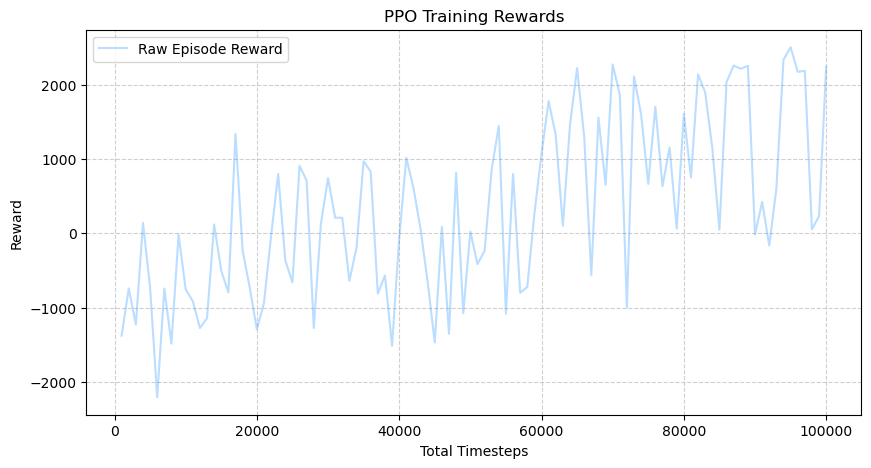

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from stable_baselines3.common.results_plotter import load_results, ts2xy

def plot_learning_curve(log_folder, title="PPO Training Rewards"):
    # Load the results from the monitor file
    x, y = ts2xy(load_results(log_folder), 'timesteps')
    
    plt.figure(figsize=(10, 5))
    
    # Plot raw rewards in light blue
    plt.plot(x, y, alpha=0.3, color='dodgerblue', label="Raw Episode Reward")
    
    # # Calculate and plot smoothed rewards
    # if len(y) > 50:
    #     # Convert to numpy array with .values to avoid the ValueError
    #     y_smoothed = pd.Series(y).rolling(window=50).mean().values
    #     plt.plot(x, y_smoothed, color='blue', linewidth=2, label="Rolling Mean (50 ep)")
    
    plt.xlabel('Total Timesteps')
    plt.ylabel('Reward')
    plt.title(title)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

# Run the plotting function
plot_learning_curve("./ppo_asv_logs/")

/home/svillhauer/.local/lib/python3.10/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


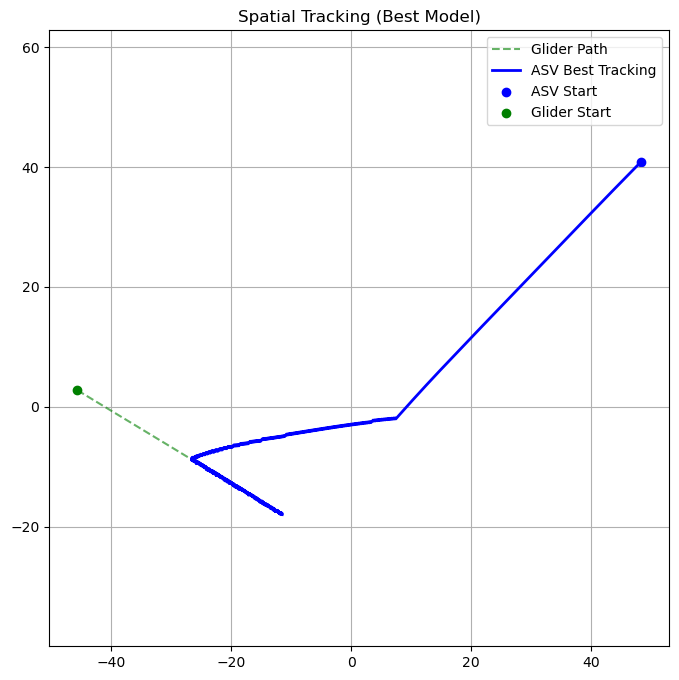

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import SAC
import os

# 1. Path to the best model
# Note: Adjust 'logs' to match the folder name you used in the EvalCallback
model_path = "./logs_ppo/best_model/best_model.zip"

if not os.path.exists(model_path):
    print(f"Error: Could not find the best model at {model_path}")
else:
    # 2. Load the best model
    model = PPO.load(model_path)
    env = AsvGliderBearingEnv()
    obs, _ = env.reset()

    asv_path, glider_path, rewards = [], [], []
    done = False

    # 3. Run a test episode
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, _ = env.step(action)
        
        asv_path.append(env.asv_pos.copy())
        glider_path.append(env.glider_pos.copy())
        rewards.append(reward)
        done = terminated or truncated

    asv_path, glider_path = np.array(asv_path), np.array(glider_path)

    # 4. Plot the Map
    plt.figure(figsize=(8, 8))
    plt.plot(glider_path[:, 0], glider_path[:, 1], 'g--', label="Glider Path", alpha=0.6)
    plt.plot(asv_path[:, 0], asv_path[:, 1], 'b-', label="ASV Best Tracking", linewidth=2)
    plt.scatter(asv_path[0,0], asv_path[0,1], c='blue', label="ASV Start")
    plt.scatter(glider_path[0,0], glider_path[0,1], c='green', label="Glider Start")
    plt.title("Spatial Tracking (Best Model)")
    plt.legend()
    plt.axis('equal')
    plt.grid(True)
    plt.show()